# Content-Based-Filtering

In [198]:
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt

from ast import literal_eval
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

## TMDB Movie Data

In [199]:
credits = pd.read_csv('datasets/tmdb_5000_movie_dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('datasets/tmdb_5000_movie_dataset/tmdb_5000_movies.csv')

In [200]:
credits.sample(1)

,movie_id,title,cast,crew
2291,62630,The Devil's Double,"[{""cast_id"": 6, ""character"": ""Latif Yahia / Ud...","[{""credit_id"": ""52fe4685c3a368484e095479"", ""de..."


In [201]:
movies.sample(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2522,14000000,"[{""id"": 36, ""name"": ""History""}, {""id"": 18, ""na...",http://theimitationgamemovie.com/,205596,"[{""id"": 237, ""name"": ""gay""}, {""id"": 392, ""name...",en,The Imitation Game,Based on the real life story of legendary cryp...,145.364591,"[{""name"": ""Black Bear Pictures"", ""id"": 22146},...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2014-11-14,233555708,113.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The true enigma was the man who cracked the code.,The Imitation Game,8.0,5723


In [202]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

## Data Exploration

In [203]:
# Rename column movie_id to id and then merging the two dataframe together on id
credits = credits.rename({'movie_id': 'id'}, axis = 1)
df = movies.merge(credits, on = 'id')

In [204]:
df = df.drop_duplicates()

In [205]:
df.shape

(4803, 23)

In [206]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

There are a lot of null values for the columns *homepage* and *tagline*. Fortunately those columns are not very important in terms of the metadata for the movies because *homepage* is just link to the movie and *tagline* is a catchphrase for a movie. Instead of *tagline* it will be much more useful to use the overview of the movies to see if movies are similar or not

In [207]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title_x                  object
vote_average            float64
vote_count                int64
title_y                  object
cast                     object
crew                     object
dtype: object

In [208]:
# Get Earlies and Latest Release Dates
df['release_date'] = pd.to_datetime(df['release_date'])
print("Earliest Release Date in dataset: " + str(min(df.release_date)))
print("Latest Release Date in dataset: " + str(max(df.release_date)))

Earliest Release Date in dataset: 1916-09-04 00:00:00
Latest Release Date in dataset: 2017-02-03 00:00:00


Text(0, 0.5, 'frequency')

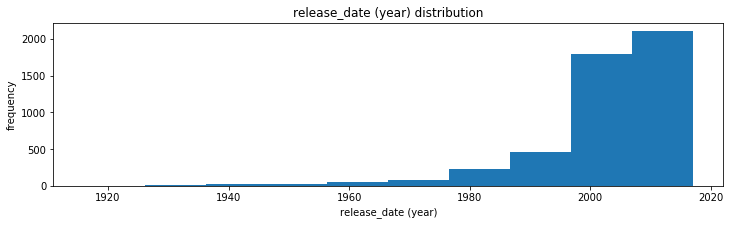

In [209]:
# Distribution of release years 
fig = plt.figure(figsize = (12,3))
plt.hist(df.release_date.dt.year)
plt.title('release_date (year) distribution')
plt.xlabel('release_date (year)')
plt.ylabel('frequency')

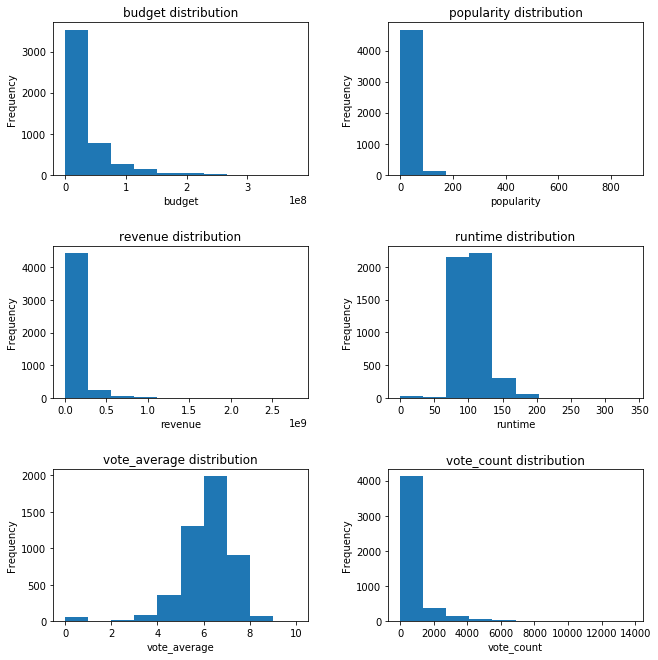

In [210]:
continuous_features = ['budget', 'popularity', 'revenue', 'runtime',
                      'vote_average', 'vote_count']

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = [10 ,10])
fig.tight_layout(pad = 5.0)
axes = axes.flatten()
position = 0
for feature in continuous_features:
    axes[position].hist(df[feature])
    axes[position].set_title(feature + " distribution")
    axes[position].set_xlabel(feature)
    axes[position].set_ylabel("Frequency")
    position = position + 1

## Simple Recommender

The simplest recommender system we can build is one that doesn't even use the metadata of the movie; recommends movies based off top-rated or popularity. This is a simple approach to recommending as movies that are popular or more highly rated will have a higher probability of being liked by the average audience.

### Recommendations Using Rating

#### Weighted Rating

From our data we have a *vote_average* feature. The *vote_average* feature is just the average rating given for that movie. This feature is a little deceiving. Just because a movie has a higher *vote_average* score than another, it does not necessarily mean it is better. This is because we need to take into the consideration the number of votes a movie has received. A movie with a *vote_average* of 8 and *vote_count* of 10 is not necessarily a better movie than one that has a *vote_average* of 7.5, but 1000 votes.

**IMDB** uses a weighted rating for their movies. The formula for the weighted rating is:

$$WR = (\frac{v}{v + m})R + (\frac{m}{v + m})C$$

* R - average rating for the movie (the *vote_average* column)
* v - number of votes for the movie (the *vote_count* column)
* m - minimum votes required to be listed (need to calculate this)
* C - average vote across entire data (need to calculate this)

In [225]:
c = df['vote_average'].mean()
m = df['vote_count'].quantile(0.75)
df = df.loc[df['vote_count'] >= m]
print(df.shape)

(1203, 15)


In [234]:
def weighted_rating(movie, m=m, c=c):
    R = movie['vote_average']
    v = movie['vote_count']
    
    weighted_rate = (v/(v+m)*R) + (m/(m+v)*c)
    return weighted_rate
    
df['weighted_rating'] = df.apply(weighted_rating, axis = 1)

In [237]:
df.sort_values('weighted_rating', ascending = False)[['original_title', 'weighted_rating']]

,original_title,weighted_rating
1881,The Shawshank Redemption,8.301547
3337,The Godfather,8.143459
662,Fight Club,8.139688
3232,Pulp Fiction,8.122458
65,The Dark Knight,8.078054
...,...,...
91,Independence Day: Resurgence,5.172190
303,Catwoman,5.102609
3746,The Boy Next Door,4.934696
210,Batman & Robin,4.847114


This is a really simple recommender system. It is recommending based on what are the best movies.

### Recommendations Using Popularity

#### Popularity

## Content-Based Filtering

### Recommendations Using the Overview

#### Term Frequency - Inverse Document Frequency (TF-IDF) On Movie Overview

We can use the *overview* column to help make recommendations. If you enjoy a movie, it is very likely you will enjoy another one with similar plot or overview.

How do we calculate the similarity between two plots? We need to convert the *overview* from a sequence of words into numbers which we can then use to calculate some sort of similarity score.

We will be using **TF-IDF** to convert the *overviews* into numbers. It calculates a score for each word in the corpus of words.

* Term Frequency - is the number of occurences of a specific term in a document (overviews).
* Document Frequency - is the number of documents (overviews) containing a specific word. This indicates how common the word is.
* Inverse Document Frequency is the weight of the word. If the word appears often throughout the movie dataset, then it does not have much weight.

$$w_{i,j} = tf_{i,j} x idf_i$$

where:

$$idf_i = log(\frac{n}{df_i})$$

In [239]:
# remove stopwords. Stopwords are common words that add no meaning to the text
tfidf = TfidfVectorizer(stop_words = 'english')

overview_matrix = tfidf.fit_transform(df['overview'])

In [242]:
overview_matrix.shape

(1203, 9610)

The shape of the tfidf matrix tells us that 9610 unique words (after removing stopwords) were used to described the 1203 movies. 

### Recommendations Using Movies Features

In [211]:
df.sample(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
782,60000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 35, ""nam...",http://www.mycityscreams.com/,8285,"[{""id"": 1308, ""name"": ""secret identity""}, {""id...",en,The Spirit,Down these mean streets a man must come. A her...,14.84856,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...",...,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,I'm gonna kill you all kinds of dead.,The Spirit,4.7,320,The Spirit,"[{""cast_id"": 6, ""character"": ""The Spirit/Denny...","[{""credit_id"": ""52fe449cc3a36847f809fee7"", ""de..."


In [212]:
df.iloc[0]

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                          2009-12-10 00:00:00
revenue                                                        2787965087
runtime                               

The following columns in the dataset contain lists of dictionaries as their values: *genres, keywords, production_companies, production_countries, spoken_languages, cast, crew*. 

We will extract the important medadata from these dictionaries and have the values in a list. 

For example, for the genre column we want the final output to look like this: [action, comedy].

We will define a couple of helper functions that will extract the necessary metadata for our dataset columns

First lets take a look at the different dictionaries and which key value we need to extract

In [238]:
dict_features = ['genres', 'keywords', 'production_companies', 
                'production_countries', 'spoken_languages',
                'cast', 'crew']

# for i in dict_features:
#     print("========================== "+ i + " =========================")
#     print(df[i].iloc[0])

* **genres** - name
* **keywords** - name
* **production_companies** - name
* **production_countries** - name
* **spoken_languages** - name
* **cast** - name
* **crew** - find "job": "Director" and get name value

We can write a function that takes all the values from the *name* key. However, as we can see from the above output, there are a lot of values for some of the features such as *cast* and *crew*. We do not want to include all those features as we will have a super high-dimension matrix that will be very sparse aswell. 

For cast we can just take the top N values because usually the people with the most screentime are listed first on the cast lists.

For crew we will just fetch the Director of the movie.

In [214]:
print(df['genres'].iloc[0])
print("")
print(df['genres'].iloc[0][0]) # First element of first movie genres dictionary

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]

[


In [215]:
# Convert strings into actual list objects

dict_features = ['genres', 'keywords', 'cast', 
                 'production_companies','crew']

for feature in dict_features:
    df[feature] = df[feature].apply(literal_eval)

print(df['genres'].iloc[0][0])

{'id': 28, 'name': 'Action'}


In [216]:
def get_director(crew_column):
    for i in crew_column:
        if i['job'] == 'Director':
            meta_data = i['name']
            return meta_data
    return np.nan


def extract_metadata(dict_column):
    
    if isinstance(dict_column, list):        
        metadata = [i['name'] for i in dict_column]
            
        if len(metadata) > 3:
            metadata = metadata[:3]
        return metadata
    return []

In [217]:
df[dict_features[-1]] = df[dict_features[-1]].apply(get_director)

for feature in dict_features[:4]:
    df[feature] = df[feature].apply(extract_metadata)

In [218]:
df[dict_features].head()

,genres,keywords,cast,production_companies,crew
0,"[Action, Adventure, Fantasy]","[culture clash, future, space war]","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Ingenious Film Partners, Twentieth Century Fo...",James Cameron
1,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island]","[Johnny Depp, Orlando Bloom, Keira Knightley]","[Walt Disney Pictures, Jerry Bruckheimer Films...",Gore Verbinski
2,"[Action, Adventure, Crime]","[spy, based on novel, secret agent]","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[Columbia Pictures, Danjaq, B24]",Sam Mendes
3,"[Action, Crime, Drama]","[dc comics, crime fighter, terrorist]","[Christian Bale, Michael Caine, Gary Oldman]","[Legendary Pictures, Warner Bros., DC Entertai...",Christopher Nolan
4,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion]","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Walt Disney Pictures],Andrew Stanton
